In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import files

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TemporalModel from the Nanduri paper
tm = ec2b.TemporalModel(model='Nanduri', tsample=5e-6)

# input amplitude values and expected output
exp_thresh = 30
all_amps = np.array([1.25, 1.5, 2, 4, 6]) * exp_thresh
out_amps = np.array([10, 15, 18, 19, 19])

# input frequency values and expected output
all_freqs = np.array([13, 20, 27, 40, 80, 120])
out_freqs = np.array([7.3, 10, 13, 19, 34, 51])

In [3]:
# Pulse train used in Nanduri et al. (2012)
def get_pulse_train(freq, ampl, pulse_dur=0.45/1000, dur=0.5, tsample=5e-6):
    return e2cm.Psycho2Pulsetrain(freq=freq, dur=dur, 
                                  pulse_dur=pulse_dur, interphase_dur=0,
                                  delay=0.,
                                  tsample=tsample, current_amplitude=ampl, 
                                  pulsetype='cathodicfirst')

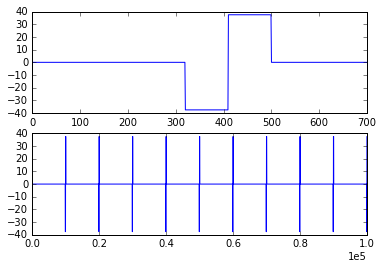

In [4]:
pulse_train = get_pulse_train(20, all_amps[0])
plt.subplot(211)
plt.plot(pulse_train.data[9500:10200])
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(pulse_train.data)

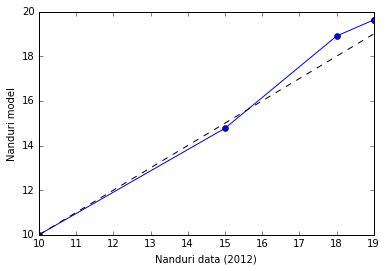

In [5]:
# Run the model on these values and compare model output vs. Nanduri data.
B = []
for ampl in all_amps:
    R4 = tm.model_cascade(get_pulse_train(20, ampl), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

# Perhaps values are just off by some scaling factor.
# Therefore, normalize so first value is B=10...
scale = B[0] / out_amps[0]
amp_nanduri = B / scale

plt.plot(out_amps, amp_nanduri, 'o-')
plt.plot([out_amps[0], out_amps[-1]], [out_amps[0], out_amps[-1]], '--k')
plt.xlabel('Nanduri data (2012)')
plt.ylabel('Nanduri model')

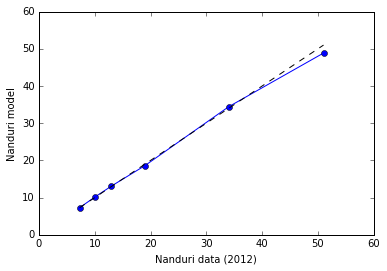

In [6]:
# Run the model on these values and compare model output vs. Nanduri data.
B = []
for freq in all_freqs:
    R4 = tm.model_cascade(get_pulse_train(freq, all_amps[1]), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

scale = B[0] / out_freqs[0]
freq_nanduri = B / scale

plt.plot(out_freqs, freq_nanduri, 'o-')
plt.plot([out_freqs[0], out_freqs[-1]], [out_freqs[0], out_freqs[-1]], '--k')
plt.xlabel('Nanduri data (2012)')
plt.ylabel('Nanduri model')

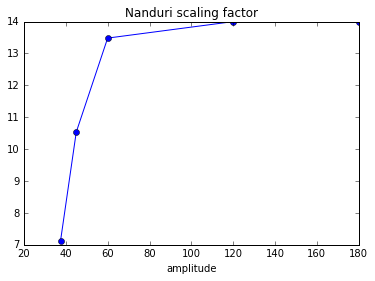

In [7]:
old_scale = []
for ampl in all_amps:
    pt = get_pulse_train(20, ampl)
    fr = tm.fast_response(pt.data, dojit=True)
    ca = tm.charge_accumulation(pt.data)
    R2 = fr - ca
    old_scale.append(tm.asymptote / (1 + np.exp(-(R2.max() - tm.shift) / tm.slope)))
old_scale = np.array(old_scale)

plt.plot(all_amps, old_scale, 'o-')
plt.xlabel('amplitude')
plt.title('Nanduri scaling factor')

In [8]:
# Let's replace the stationary_nonlinearity step with a
# Horsager-style power nonlinearity `beta`:
class NewTemporalModel(ec2b.TemporalModel):
    def stationary_nonlinearity(self, b3):
        return np.maximum(0, b3) ** self.beta

In [9]:
ntm = NewTemporalModel(model='Nanduri')

In [10]:
# Now, instead of the logistic function that is currently implemented:
# What `beta` would be required (as a function of amplitude) 
# to make the model output match the Nanduri amplitude data?

# Search a wide range of scaling factors
scales = np.linspace(1, 3, 1000)

all_err = []
all_scale = []
all_R2 = []
for ampl, tb in zip(all_amps, out_amps):
    pt = get_pulse_train(20, ampl)
    
    # calculate the MSE for a given scaling factor
    err = []
    R2 = []
    for s in scales:
        ntm.beta = s
        R1 = ntm.fast_response(pt.data, dojit=True)
        ca = ntm.charge_accumulation(pt.data)
        diff = R1 - ca
        R2.append(diff.max())
        
        R4 = ntm.slow_response(ntm.stationary_nonlinearity(diff))
        err.append((R4.max() - tb)**2)
        
    # find the scaling factor that gives the smallest error
    all_err.append(min(err))
    all_scale.append(scales[np.argmin(err)])
    all_R2.append(R2[np.argmin(err)])
    
all_err = np.array(all_err)
all_scale = np.array(all_scale)
all_R2 = np.array(all_R2)

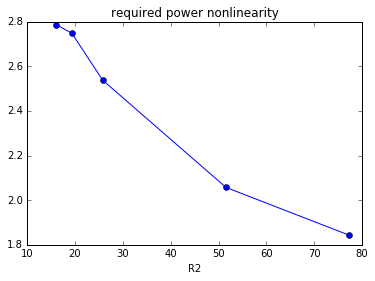

In [11]:
# Looks like a decaying exponential function...
plt.plot(all_R2, all_scale, 'o-')
plt.xlabel('R2')
plt.title('required power nonlinearity')

In [12]:
# try to fit the curve with a decaying exponential
def expdecay(x, n0, lam, shift):
    return np.minimum(all_scale.max(), n0 * np.exp(-lam*x) + shift)

In [13]:
x = all_R2 / 200

n0 = np.linspace(1.5, 2.5, 100)
lam = np.linspace(6, 7, 100)
shi = np.linspace(1, 2, 100)

best_err = np.inf
best_n0 = -1
best_lam = -1
best_s = 0
for n in n0:
    for l in lam:
        for s in shi:
            err = np.sum((expdecay(x, n, l, s) - all_scale) ** 2)
            if err < best_err:
                best_err = err
                best_n0 = n
                best_lam = l
                best_s = s

[best_err, best_n0, best_lam, best_s]

[4.9730314444181061e-05,
 1.994949494949495,
 6.5656565656565657,
 1.6868686868686869]

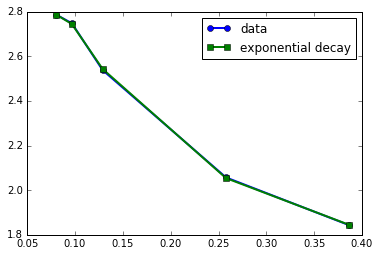

In [14]:
plt.plot(x, all_scale, '-o', linewidth=2, label='data')
plt.plot(x, expdecay(x, best_n0, best_lam, best_s), '-s', linewidth=2, label='exponential decay')
plt.legend()

In [15]:
# Case in point: If we apply these scaling factors correctly as a function of amplitude,
# our new implementation should match the Nanduri data
class ExtendedHorsagerModel(ec2b.TemporalModel):
    def stationary_nonlinearity(self, b3):
        beta = best_n0 * np.exp(-best_lam * b3.max() / 200) + best_s
        return np.maximum(0, b3) ** np.minimum(all_scale.max(), beta)

horsager = ExtendedHorsagerModel(model='Nanduri')
horsager = ec2b.TemporalModel(model='Horsager')

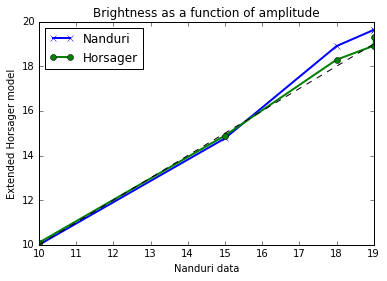

In [16]:
B = []
for ampl,s in zip(all_amps, all_scale):
    R4 = horsager.model_cascade(get_pulse_train(20, ampl), dojit=True)
    B.append(R4.data.max())
B = np.array(B)

plt.plot(out_amps, amp_nanduri, '-x', linewidth=2, label='Nanduri')
plt.plot(out_amps, B, '-o', linewidth=2, label='Horsager')
plt.plot([out_amps[0], out_amps[-1]], [out_amps[0], out_amps[-1]], '--k')
plt.xlabel('Nanduri data')
plt.ylabel('Extended Horsager model')
plt.title('Brightness as a function of amplitude')
plt.legend(loc='upper left')

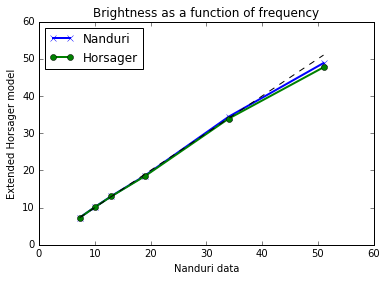

In [17]:
B = []
for freq in all_freqs:
    ntm.beta = all_scale[0]
    R4 = horsager.model_cascade(get_pulse_train(freq, all_amps[0]), dojit=True)
    B.append(R4.data.max())

plt.plot(out_freqs, freq_nanduri, '-x', linewidth=2, label='Nanduri')
plt.plot(out_freqs, B, '-o', linewidth=2, label='Horsager')
plt.plot([out_freqs[0], out_freqs[-1]], [out_freqs[0], out_freqs[-1]], '--k')
plt.xlabel('Nanduri data')
plt.ylabel('Extended Horsager model')
plt.title('Brightness as a function of frequency')
plt.legend(loc='upper left')

In [21]:
# Run the model on different amplitude values
in_amp_full = np.linspace(0, 180, 50)
bright_amp_full = []
for ampl in in_amp_full:
    R4 = horsager.model_cascade(get_pulse_train(all_freqs[1], ampl), dojit=True)
    bright_amp_full.append(R4.data.max())
bright_amp_full = np.array(bright_amp_full)

in_freq_full = np.linspace(0, 180, 50)
bright_freq_full = []
for freq in in_freq_full:
    if freq == 0:
        bright_freq_full.append(0)
        continue

    R4 = horsager.model_cascade(get_pulse_train(freq, all_amps[0]), dojit=True)
    bright_freq_full.append(R4.data.max())
bright_freq_full = np.array(bright_freq_full)

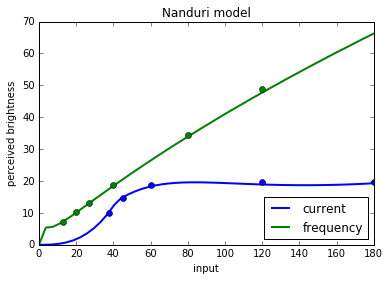

In [22]:
plt.plot(in_amp_full, bright_amp_full, 'b', linewidth=2, label='current')
plt.plot(in_freq_full, bright_freq_full, 'g', linewidth=2, label='frequency')
plt.plot(all_amps, amp_nanduri, 'ob')
plt.plot(all_freqs, freq_nanduri, 'og')
plt.xlabel('input')
plt.ylabel('perceived brightness')
plt.title('Nanduri model')
plt.legend(loc='lower right')

In [18]:
meow + 2

NameError: name 'meow' is not defined

In [23]:
r_sampling = 250  # spatial sampling of retina
r_file = '../retina_argus_s' + str(r_sampling) + '.npz'
r = e2cm.Retina(axon_map=r_file, sampling=r_sampling,
                xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)

In [24]:
e_all = e2cm.ElectrodeArray([260], [0], [0], [100])
ecs, cs  = r.electrode_ecs(e_all)

In [ ]:
for i in range(len(all_amps)):
    R4 = ec2b.pulse2percept(horsager, cs, r, [get_pulse_train(all_freqs[1], all_amps[i])], 
                            30, n_jobs=4, dojit=True, tol=0.01)
    plt.subplot(1, len(all_amps), i + 1)
    plt.imshow(R4.data[:, :, 150] / scale_amp, cmap='gray', vmin=0, vmax=25)
    plt.axis('off')
    plt.title("B={:.2f}".format(R4.data.max() / scale_amp))

In [ ]:
for i in range(len(all_freqs)):
    R4 = ec2b.pulse2percept(horsager, cs, r, [get_pulse_train(all_freqs[i], all_amps[0])], 
                            30, n_jobs=4, dojit=True, tol=0.01)
    plt.subplot(1, len(all_freqs), i + 1)
    plt.imshow(R4.data[:, :, 150] / scale_freq, cmap='gray', vmin=0, vmax=50)
    plt.axis('off')
    plt.title("B={:.2f}".format(R4.data.max() / scale_freq))